Методы анализа данных и машинного обучения.

Финальный проект. Оценка и прогноз сроков производства изделий для типографии.

__Структура__
- [Вводные. Краткое описание сути данных](#intro)
- [Проблема. Короткое исследование, приведшее к обнаружению проблемы](#problem)
- [Цели. Задачи](#target)
- [Данные. Отдельные ноутбуки с описанием процесса выгрузки и подготовки данных](#data)
- [Анализ](#study)
- [Обучение](#model)

In [7]:
# # Часть проекта вынесена в библиотеки
# ! wget https://storage.yandexcloud.net/www.eugenegantz.ru/box/jknznqhakzo/index.zip
# ! unzip -qq index.zip

In [2]:
import json
import re
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics
from IPython.display import display

In [2]:
sys.version

'3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]'

In [3]:
# общие утилиты
import lib.utils as utils

# утилиты для работы с товарной номенклатурой
import lib.gands as gands

# утилиты для обработки данных
import lib.data_processing as data_utils

In [4]:
GLOBAL_RANDOM_STATE = 128
Y_TARGETS = ['prod_t', 'sum']
Y1_TARGET = Y_TARGETS[0]
Y2_TARGET = Y_TARGETS[1]
Y_TARGET = Y1_TARGET

In [5]:
# импортировать данные подготовленные из учетной системы
def _import_data_from_file(filepath, filter_func=utils.stubTrue):
    f = open(filepath, 'r', encoding='utf-8')
    train = json.loads(''.join(f.readlines()))

    rows = []
    props = dict()

    for row in train:
        for k in row:
            props[k] = 1

    for row in train:
        _row = dict()

        for k in props:
            _row[k] = row.get(k, '')

        if filter_func(_row):
            rows.append(_row)

    return pd.DataFrame(rows)

In [6]:
# словарь номенклатуры
gsref = gands.GSRef('./data/gands/gands.json')

In [7]:
# Импортировать расчетные сроки изготовления из API магазина
f = open('./data/calc/prod_t.json')
df_prod_t_calc = pd.DataFrame(
    data=json.loads(''.join(f.readlines())),
    columns=['mmid', 'prod_t'],
)

In [8]:
# Все изделия
df_all = _import_data_from_file('./data/crm/train.json')

In [9]:
df = df_all
df

,mmid,gs,prod_t,sum,user_groups,gsdate_ts,gsdate2_ts,userId,gsid,post_id,...,цветность перекидных листов,количество листов в блоке,вид значка,тип коробки,размер коробки,цвет ленты,цвет нанесения,способ упаковки,макет основы,добавить цепочку
0,1457017,ГПШрПЛ02,8708.0,1114.0,1,1.641298e+09,1.641820e+09,12.281157,ТСИЗ3201,230,...,,,,,,,,,,
1,1463859,ГППКПК,4457.0,9290.0,7,1.642162e+09,1.642429e+09,12.230668,ТСИЗ0601,221,...,,,,,,,,,,
2,1465559,ГПИНПР,5231.0,3000.0,1,1.641827e+09,1.642141e+09,12.244904,ТСИЗ1601,297,...,,,,,,,,,,
3,1467195,ГППКПК,3234.0,3490.0,3,1.641800e+09,1.641994e+09,12.237959,ТСИЗ0601,221,...,,,,,,,,,,
4,1467211,ГППОВиФо,1998.0,3330.0,7,1.641762e+09,1.641882e+09,12.231175,ТСИЗ0201,1,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10223,1641007,ГПСУПОК1,391.0,448.0,1,1.659079e+09,1.659102e+09,12.287791,ГПСУПОК1,227,...,,,,,,,,,,
10224,1641014,ГПШрПЛ02,4462.0,2544.0,7,1.659096e+09,1.659364e+09,12.223701,ГПШрПЛ,22,...,,,,,,,,,,
10225,1641212,ГПШрПЛ01,4261.0,781.0,7,1.659081e+09,1.659336e+09,12.242964,ГПШрПЛ,22,...,,,,,,,,,,
10226,1641446,ГПШрПЛ02,157.0,140.0,3,1.659092e+09,1.659101e+09,12.263176,ГПШрПЛ,22,...,,,,,,,,,,


<a id="intro"></a>
### Вводные. Краткое описание сути данных

Источник данных -- интернет-магазин рекламной продукции.
Учет заказов, работ и вообще всех бизнес процессов ведется во внутренней системе учета задач собственной разработки.

Клиент выбирает тип изделия, которое желает приобрести, и попадает на форму-конструктор. На странице с формой клиент собирает себе полностью кастомизированное изделие. Так, например, в случае с наклейками (они же стикеры), клиенту доступно около 450 вариантов (комбинаций) различных стикеров.

Всего, рядовому клиенту доступно около 70 типов кастомизируемых изделий.

Сложная продукция приводит к сложному производственному процессу. Существуют различные подходы к изготовлению одного и того же типа изделия (в зависимости от кастомизации). Это порождает сложности при расчёте стоимости и сроков производства.

Клиент прямо на странице "на лету" получает информацию о стоимости текущего варианта изделия и примерные сроки изготовления.

In [ ]:
https://drive.google.com/file/d/1WKPCuw18IUKL6TbndZpladLaC4cZMoOF/view?usp=sharing

<a id='problem'></a>
### Проблема. Короткое исследование, приведшее к обнаружению проблемы

- Загрузить данные об произведенных изделиях из учетной системы.
- Извлечь из полученных данных информацию о фактически затраченном времени на производство.
- Рассчитать сроки производства для полученных изделий на калькуляторе в интернет-магазине (Алгоритм. Расчетное время для покупателя)
- Сравнить фактические сроки производства со сроками полученных из калькулятора.

Данные уже получены выше. Процесс выгрузки и подготовки данных описан в отдельном блокноте.

Ниже построены гистограммы распределения времени для обоих случаев

r2_score = -0.48186616468903076
mse_score = 23839342.73921228


,tc,t,abs(t - tc),(t / tc)
0,622.484762,1998,1375.515238,3.209717
1,1262.567568,2246,983.432432,1.778915
2,1262.567568,1040,222.567568,0.823718
3,976.682271,643,333.682271,0.658351
4,589.163265,868,278.836735,1.473276
5,1080.000000,435,645.000000,0.402778
6,1620.000000,10079,8459.000000,6.221605
7,1620.000000,11489,9869.000000,7.091975
8,1620.000000,8812,7192.000000,5.439506
9,1620.000000,8358,6738.000000,5.159259


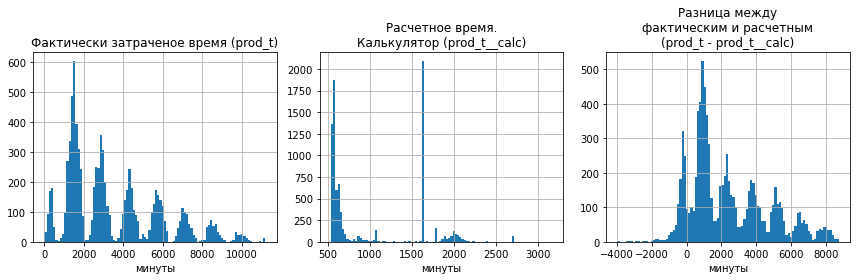

In [25]:
#
# Построить гистрограмму распределения времени производства
#

def f():
    plt.figure(figsize=(12, 4))
    
    _df = df.join(df_prod_t_calc.set_index('mmid'), on='mmid', rsuffix='__calc')
    _df = _df[_df['prod_t__calc'].isna() == False]
    
    # -------
    
    fig = plt.subplot(1, 3, 1)
    plt.title('Фактически затраченое время (prod_t)')
    data_utils.f_remove_outlier_iqr(_df['prod_t']).hist(bins=100)
    plt.tight_layout()
    fig.set_xlabel('минуты')
    plt.plot()
    
    # -------
    
    fig = plt.subplot(1, 3, 2)
    plt.title('Расчетное время.\nКалькулятор (prod_t__calc)')
    data_utils.f_remove_outlier_iqr(_df['prod_t__calc']).hist(bins=100)
    plt.tight_layout()
    fig.set_xlabel('минуты')
    plt.plot()
    
    # -------
    
    _diff = _df['prod_t'] - _df['prod_t__calc']
    _diff = data_utils.f_remove_outlier_iqr(_diff)

    fig = plt.subplot(1, 3, 3)
    plt.title('Разница между\nфактическим и расчетным\n(prod_t - prod_t__calc)')
    _diff.hist(bins=100)
    plt.tight_layout()
    fig.set_xlabel('минуты')
    plt.plot()
    
    # -------
    
    _print = []
    prod_t = _df['prod_t'].values
    prod_tc = _df['prod_t__calc'].values
    
    print('r2_score = ' + str(metrics.r2_score(prod_t, prod_tc)))
    print('mse_score = ' + str(metrics.mean_squared_error(prod_t, prod_tc)))
    
    for i, _ in enumerate(prod_t):
        t = prod_t[i]
        tc = prod_tc[i]
        
        if i < 10:
            _print.append({
                'tc'          : tc,
                't'          : t,
                'abs(t - tc)' : abs(tc - t),
                '(t / tc)'    : t / tc
            })
            
    display(pd.DataFrame(_print))
f()

prod_t -- фактическое время изготовления  
prod_t__b -- прогнозируемое/расчетное время изготовления  
(prod_t - prod_t__b) -- разница между ожидаемым и фактическим

__prod_t__  
Фактический срок производства изделия.  
Является целевой переменной.  
Сильно разбалансирован.  
Очень интересное распределение времени работы: многомодальное, 8 пиков.

Думаю, это как-то связано с рабочими днями недели и тем как люди на производстве планируют свое время.  
2000 минут это 33 часа, что примерно как рабочая неделя. Похоже, что производство старается закончить заказ до конца рабочей недели.

__prod_t_\_calc__  
Расчетный срок производства изделия.  
Это примерные сроки, которые доступны клиентам интернет-магазина при сборке изделия в форме.  
Сильно разбалансирован.  
Расчетный срок является результатом работы алгоритма. Для каждого изделия описан собственный алгоритм. Алгоритм не привязан к загруженности производства, рабочим неделям или личному графику производства. Думаю, по этому мы не наблюдаем такого по-недельного распределения.

__prod_t  -  prod_t_\_calc__  
В последнем случае есть даже отрицательные значения, что значит в небольшое количестве случаев есть переоценка сроков.  
В большинстве же случаев мы наблюдаем, что сроки были недооценены (визуально 5 из 7 случаев).  
Это значит, что клиентам потребовалось ждать готовности дольше, чем им об этом сообщал алгоритм.  
Я думаю, это можно считать серьезной проблемой для клиентского сервиса.

r2_score ~= -0.48

Это и является отправной точкой для данной работы.
Ниже я попробую обучить модель прогнозировать сроки производства (prod_t) и тем самым приблизить оценку сроков для клиента ближе к адекватным.

<a id="target"></a>
### Цели. Задачи

__Цель:__
- Прогнозировать целевую переменную prod_t -- время затрачиваемое на изготовление изделия (в минутах)
    - метрика r2_score

__Задачи__:
- Собрать данные
- Выявить признаки, влияющие на prod_t
- По возможности, выяснить почему алгоритмический прогноз не работает
- Собрать модель для прогноза сроков производства продукции

<a id="data"></a>
### Данные. Отдельные ноутбуки с описанием процесса выгрузки и подготовки данных

__Данные__
- Выгрузки из базы данных учетной системы.
- Расчет сроков из калькулятора. Реализован как api в магазине

__Выгрузка данных__

Выгрузка и первичная подготовка данных вынесена в отдельные ноутбуки.  
Их можно посмотреть ниже по ссылкам

- [Выгрузка данных из учетной системы](data-extraction-crm.ipynb)
- [Выгрузка данных из калькулятора](data-extraction-calc.ipynb)

<a id="study"></a>
### Анализ

In [10]:
# Привести типы данных для простоты работы с ними
tcaster = data_utils.DFTypeCaster(gsref)

df = tcaster.auto_type_cast_df(df)

df.dtypes

mmid                   int64
gs                  category
prod_t                 int64
sum                  float64
user_groups            int64
                      ...   
цвет ленты          category
цвет нанесения      category
способ упаковки     category
макет основы        category
добавить цепочку    category
Length: 176, dtype: object

Узнать, как изменились сроки производства по времени с начала года.  
Попытаться рассчитать нагрузку на производство как сумма времени задач на неделю

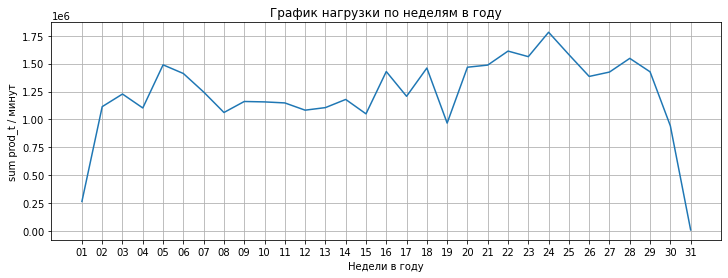

In [11]:
def f():
    def _apply(ts):
        return datetime.datetime.fromtimestamp(ts)

    _df = df.copy()
    _df = _df[['prod_t', 'gsdate_ts']]
    _df['gsdate_dt'] = _df['gsdate_ts'].apply(_apply)

    # Сгруппировать по неделям в году
    _by = _df['gsdate_dt'].dt.strftime('%U')
    
    # Сумма prod_t для i-ой недели в году
    _agg = _df.groupby(_by)['prod_t'].agg('sum')

    plt.figure(figsize=(12, 4))
    plt.grid(True)
    plt.title('График нагрузки по неделям в году')
    plt.xlabel('Недели в году')
    plt.ylabel('sum prod_t / минут')
    plt.plot(_agg.index.values, _agg.values)
f()

Видно, что нагрузка распределена неравномерно  
От себя добавлю, что дни перед новым годом самые загруженные, а первые дни нового года — это дни простоя

Можно попробовать включить недельный уровень нагрузки в качестве параметра модели

Рассчитать текущую нагрузку.  
Будем считать, что текущая нагрузка — это суммарное время уже запущенной работы (остаток) на момент запуска новой

то есть  
`row[k][gsdate_ts] < row[i][gsdate_ts] < row[k][gsdate2_ts]`  
или  
`row[k][время_запуска] < row[i][время_запуска] < row[k][время_завершения]`

где  
`row[k] -- Другие задачи (запущенные работы)`  
`row[i] -- Текущая задача (новая работа)`

Реализация вынесена в библиотеку
```python
df = data_utils.df_calc_prod_load(df)
```

g:\program_files\python\python385-64\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


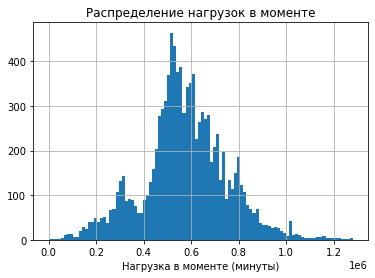

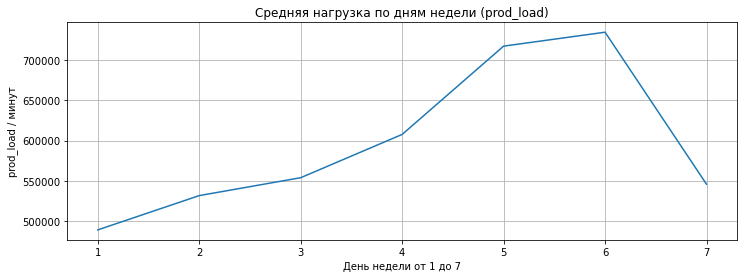

In [16]:
def f():
    def _apply(ts):
        return datetime.datetime.fromtimestamp(ts)
    
    _df = data_utils.df_calc_prod_load(df)
    
    _df.loc[:, 'gsdate_dt'] = _df['gsdate_ts'].apply(_apply)
    
    # ----------------------
    
    _df['prod_load'].hist(bins=100)
    plt.title('Распределение нагрузок в моменте')
    plt.xlabel('Нагрузка в моменте (минуты)')
    
    # ----------------------
    
    # %u - ISO 8601 weekday as a decimal number where 1 is Monday.
    # Сгруппировать дням недели
    _byweekday = _df['gsdate_dt'].dt.strftime('%u')
    
    # Средняя нагрузка для i-го дня в неделе
    _agg = _df.groupby(by=_byweekday)['prod_load'].agg('mean')

    plt.figure(figsize=(12, 4))
    plt.title('Средняя нагрузка по дням недели (prod_load)')
    plt.grid(True)
    plt.xlabel('День недели от 1 до 7')
    plt.ylabel('prod_load / минут')
    plt.plot(_agg.index.values, _agg.values)
f()

Можно интерпретировать так, что к концу недели нагрузка нарастает.  
Потому что prod_load практически суммирует остаточное время еще незакрытых задач.

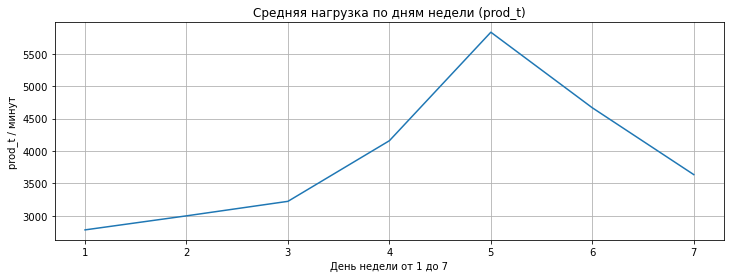

In [17]:
def f():
    def _apply(ts):
        return datetime.datetime.fromtimestamp(ts)

    _df = df.copy()
    _df = _df[['prod_t', 'gsdate_ts']]
    _df['gsdate_dt'] = _df['gsdate_ts'].apply(_apply)

    # %u - ISO 8601 weekday as a decimal number where 1 is Monday.
    # Сгруппировать дням недели
    _by = _df['gsdate_dt'].dt.strftime('%u')
    
    # Сумма "prod_t" для i-го дня в неделе
    _agg_sum = _df.groupby(_by)['prod_t'].agg('mean')

    plt.figure(figsize=(12, 4))
    plt.title('Средняя нагрузка по дням недели (prod_t)')
    plt.grid(True)
    plt.xlabel('День недели от 1 до 7')
    plt.ylabel('prod_t / минут')
    plt.plot(_agg_sum.index.values, _agg_sum.values)
f()

Если буквально интерпретировать график, то получается, что к ближе к концу недели производство запускает в работу задачи на среднее количество времени большее чем в начале недели.

(хотя, вроде, это не имеет смысла)

Это можно интерпретировать так

1. Аврал на конец недели. Производство пытается закончить все задачи к концу рабочей недели.
2. Либо просто работу запускают в конце недели, но с переносом через выходные

Думаю, имеет смысл включить день недели как параметр модели

Для такого количества изделий и признаков почти любая визуализация бессмысленна  
Попробуем рассмотреть изделия изолировано, выбрав несколько популярных

--------------------
gs value_counts:
--------------------


ГПШрПЛ01    2051
ГППО35В1    1568
ГППООИЛс     721
ГППОНАСА     576
ГПШрБа03     486
Name: gs, dtype: int64

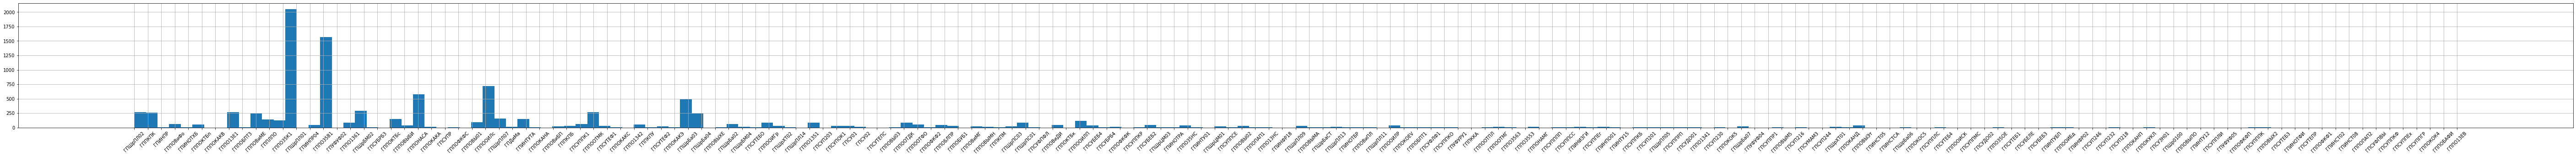

--------------------
gsid value_counts:
--------------------


ГПШрПЛ      2374
ТСИЗ0201    1886
ТСИЗ1101    1040
ГПШрБа       795
ТСИЗ3201     662
Name: gsid, dtype: int64

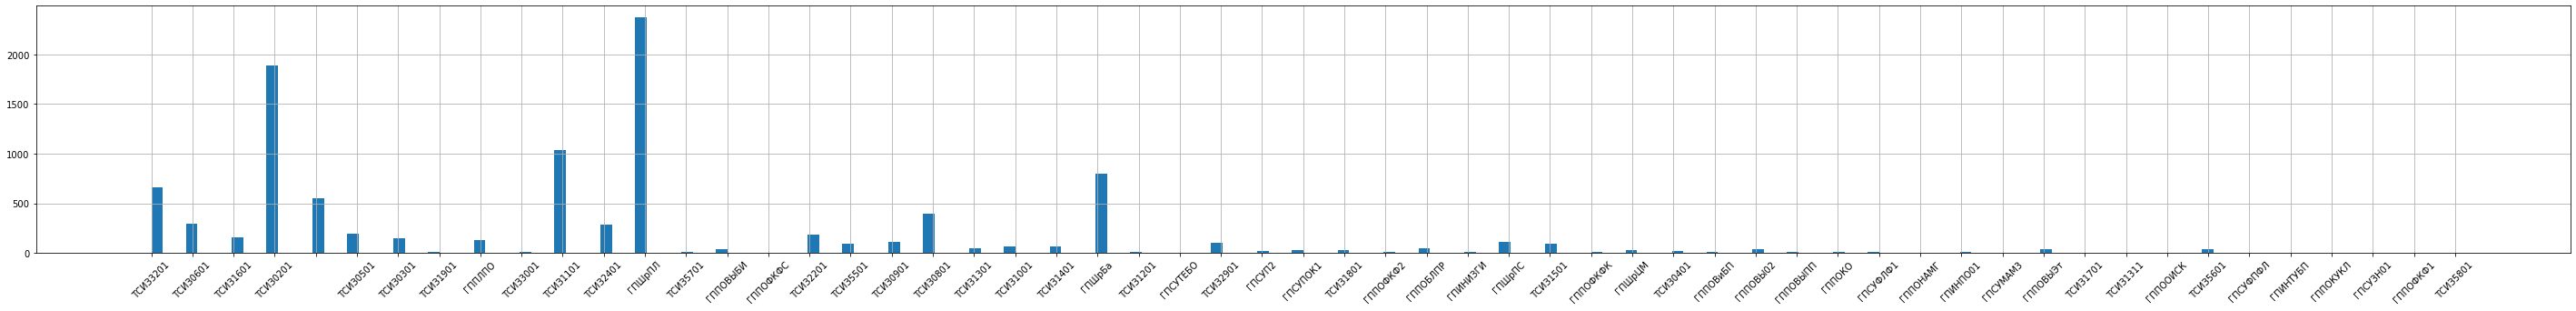

In [15]:
TOP_N = 5
PRIMARY_GS_KEY = 'gs'

def f():
    global top_gs_codes
    global top_gsid_codes
    
    # Код наименования конечного изделия

    print('--------------------')
    print('gs value_counts:')
    print('--------------------')
    top_gs_codes = df['gs'].value_counts()[:TOP_N]
    display(top_gs_codes)

    plt.subplots(figsize=(100,5))
    df['gs'].hist(xrot=45, bins=200)
    plt.show()



    print('--------------------')
    print('gsid value_counts:')
    print('--------------------')
    top_gsid_codes = df['gsid'].value_counts()[:TOP_N]
    display(top_gsid_codes)

    # Код формы товара
    plt.subplots(figsize=(50,5))
    df['gsid'].hist(xrot=45, bins=200)
    plt.show()

    top_gs_codes = top_gs_codes.index.values
    top_gsid_codes = top_gsid_codes.index.values
    
    # Формы товара описывает создание множества наименований конечного изделия
    # Итог зависит от того сочетания, что выбрал клиент в форме на странице товара
    # Форма -- по сути конструктор
f()

В выборке шире всего представлена номенклатуры:

| pos | gsid     | gs       | описание
| --- | -------- | ---------| -----------------
| 1   | ГПШрПЛ   | ГПШрПЛ01 | широкоформатная печать на пленке (уличные баннеры)
| 2   | ТСИЗ0201 | ГППО35В1 | визитка, карточка
| 3   | ТСИЗ1101 | ГППООИЛс | листовка
| 3   | ГПШрБа   | ГПШрБа03 | баннер
| 4   | ТСИЗ3201 | ГППОНАСА | наклейки ("стикеры", "самоклейки")

Посмотрим изменилось ли время, затрачиваемое производством на изготовление изделий в течении времени с начала с года.

<ipython-input-19-4802ca2ece38>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  _df['gsdate_dt'] = _df['gsdate_ts'].astype('int64').apply(_apply)


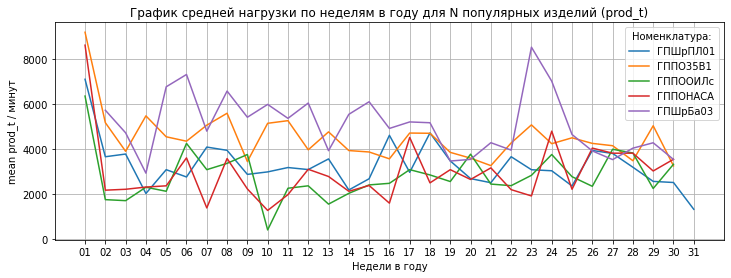

In [19]:
def f(): 
    def _apply(ts):
        return datetime.datetime.fromtimestamp(ts)
    
    _df = df.copy()

    # Выбрать N популярных изделий
    _df = _df[_df[PRIMARY_GS_KEY].isin(top_gs_codes)]
    
#     _df = _df[['gs', 'gsid', 'prod_t', 'gsdate_ts']]

    # Привести timestamp в datetime
    _df['gsdate_dt'] = _df['gsdate_ts'].astype('int64').apply(_apply)
    
    plt.figure(figsize=(12, 4))
    plt.grid(True)
    plt.title('График средней нагрузки по неделям в году для N популярных изделий (prod_t)')
    
    for gs in top_gs_codes:
        # Выбрать наименование проудкции
        _dfgs = _df[_df[PRIMARY_GS_KEY] == gs]
        
        # Сгруппировать по неделям в году
        _byweek = _dfgs['gsdate_dt'].dt.strftime('%U')
        
        # Средний "prod_t" для i-ой недели в году
        _agg  = _dfgs.groupby(by=_byweek)['prod_t'].agg('mean')

        fig = plt.plot(_agg.index.values, _agg.values, label=gs)
        plt.legend(title='Номенклатура:')
        plt.xlabel('Недели в году')
        plt.ylabel('mean prod_t / минут')
f()

Малоинформативный.  
Среднее время производства не постоянное. Наблюдаются пики с разницей почти в неделю рабочего времени (2000 минут или 33 часа).

<ipython-input-20-b6c7a8403494>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  _df['gsdate_dt'] = _df['gsdate_ts'].astype('int64').apply(_apply)


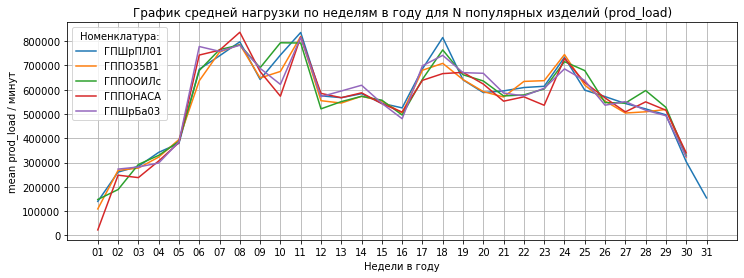

In [20]:
def f(): 
    def _apply(ts):
        return datetime.datetime.fromtimestamp(ts)

    # Посчитать prod_load
    _df = data_utils.df_calc_prod_load(df)

    # Выбрать N популярных изделий
    _df = _df[_df[PRIMARY_GS_KEY].isin(top_gs_codes)]
    
    # Привести timestamp к datetime
    _df['gsdate_dt'] = _df['gsdate_ts'].astype('int64').apply(_apply)
    
    plt.figure(figsize=(12, 4))
    plt.grid(True)
    plt.title('График средней нагрузки по неделям в году для N популярных изделий (prod_load)')
    
    for gs in top_gs_codes:
        # Выбрать наименование проудкции
        _dfgs   = _df[_df[PRIMARY_GS_KEY] == gs]
        
        # Сгруппировать по неделям в году
        _byweek = _dfgs['gsdate_dt'].dt.strftime('%U')
        
        # Средний "prod_t" для i-ой недели в году
        _agg  = _dfgs.groupby(by=_byweek)['prod_load'].agg('mean')

        fig = plt.plot(_agg.index.values, _agg.values, label=gs)
        plt.legend(title='Номенклатура:')
        plt.xlabel('Недели в году')
        plt.ylabel('mean prod_load / минут')
f()

Корреляция prod_t к остальным признакам


prod_t                         1.000000
weekday                        0.217646
загрузите макет                0.158642
prod_load                      0.153939
контурная порезка на рулоне    0.099300
gsid                           0.079013
ламинация                      0.074817
способ печати                  0.060995
user_groups                    0.047573
монтажная пленка               0.047446
Name: prod_t, dtype: float64

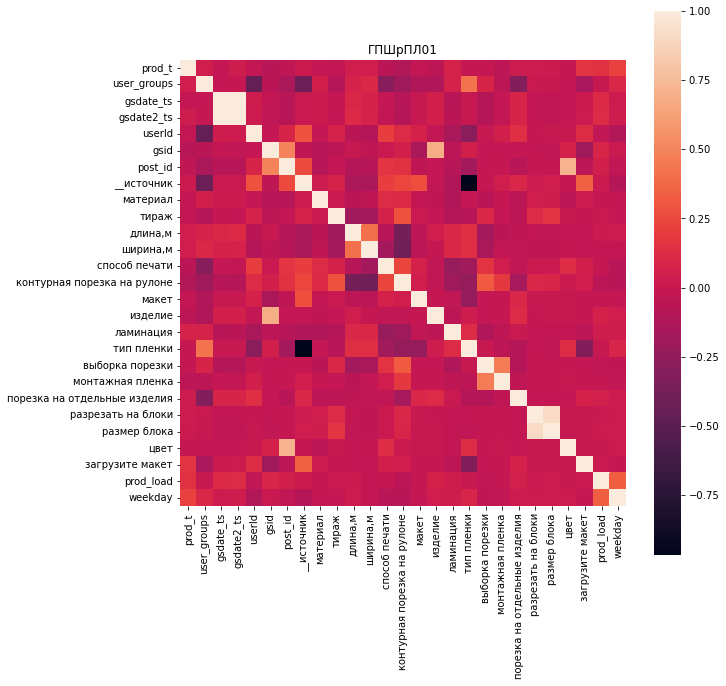

Корреляция prod_t к остальным признакам


prod_t               1.000000
weekday              0.262462
user_groups          0.189826
prod_load            0.152737
userId               0.150887
закругление углов    0.093039
gsdate_ts            0.090261
gsdate2_ts           0.055268
цветность            0.044692
тираж                0.031268
Name: prod_t, dtype: float64

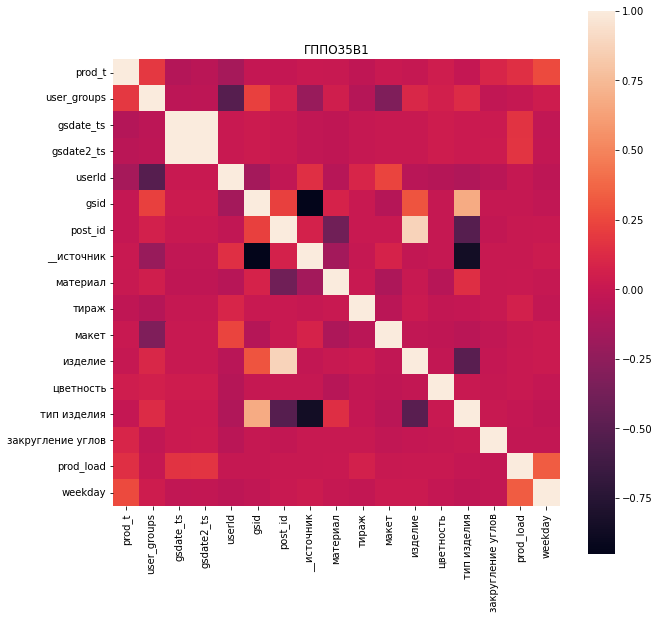

Корреляция prod_t к остальным признакам


prod_t           1.000000
weekday          0.317511
prod_load        0.280736
способ печати    0.177642
user_groups      0.163380
gsdate2_ts       0.151127
цветность        0.138936
ламинат          0.127495
userId           0.126387
gsdate_ts        0.122397
Name: prod_t, dtype: float64

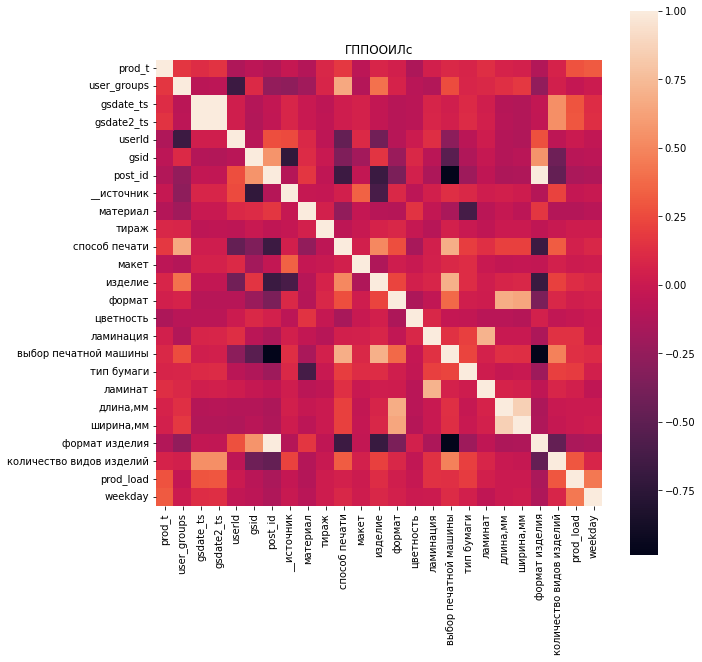

Корреляция prod_t к остальным признакам


prod_t                          1.000000
user_groups                     0.322038
weekday                         0.254463
gsdate2_ts                      0.222764
gsdate_ts                       0.200397
порезка на отдельные изделия    0.178920
userId                          0.171687
тираж                           0.153884
prod_load                       0.140556
печать белым цветом             0.133280
Name: prod_t, dtype: float64

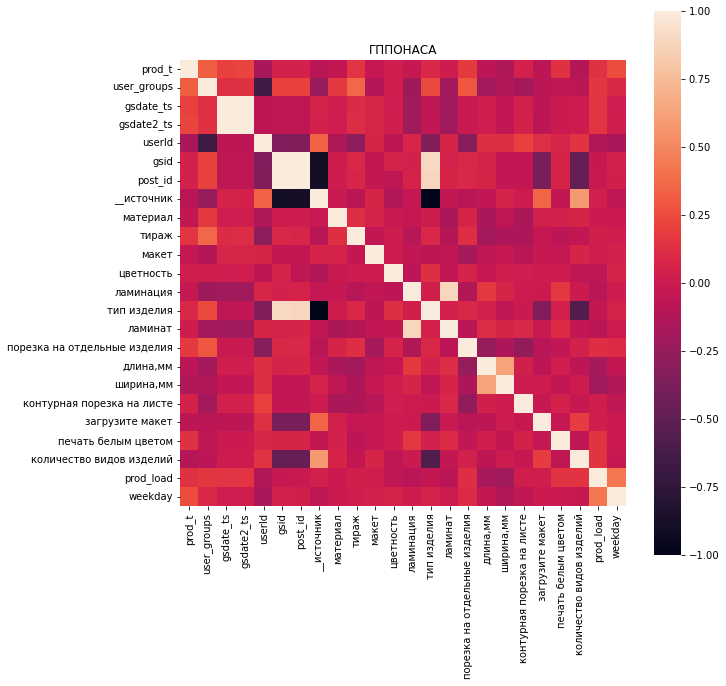

Корреляция prod_t к остальным признакам


prod_t             1.000000
weekday            0.335691
prod_load          0.214327
ширина,м           0.152501
длина,м            0.145965
gsdate_ts          0.131442
изделие            0.130820
качество печати    0.117252
gsdate2_ts         0.089609
пропайка           0.067581
Name: prod_t, dtype: float64

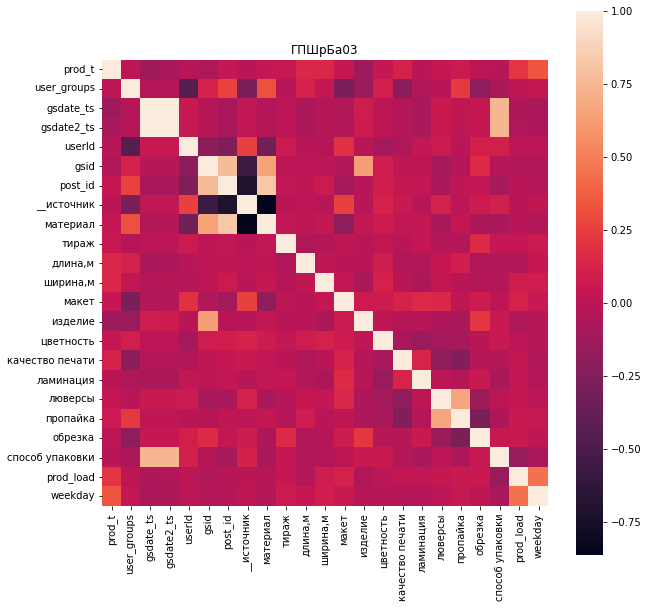

In [16]:
# Показать матрицу корреляции для трех популярных иделий

def f():
    gsid_list = top_gs_codes

    local_df = df.copy()

    local_df.drop(columns=['mmid', 'sum'], inplace=True)

    local_df = data_utils.df_calc_prod_load(local_df, inplace=True)
    local_df = data_utils.df_add_weekday(local_df, 'gsdate_ts', 'weekday')

    for _gsid in gsid_list:
        # Вернуть записи только для указанного наименования
        dfgs = local_df[local_df['gs'] == _gsid]

        # Удалить колонки где нет никаких значений
        dfgs = data_utils.remove_empty_columns(dfgs, inplace=False, print_dropped_columns=False)
        
        # Привести категориальные признаки к числам
        dfgs = data_utils.df_cat_to_ord_enc(dfgs, inplace=False)

        # Вернуть матрицу корреляций
        corr = dfgs.corr()
        
        print('Корреляция prod_t к остальным признакам')
        display(corr[Y_TARGET].apply(abs).sort_values(ascending=False)[0:10])

        plt.subplots(figsize=(10,10))
        plt.title(_gsid)
        sns.heatmap(corr, square=True)
        plt.show()
f()

Корреляция слабая. Это говорит о том, что нет линейной зависимости.

С другой стороны, в некоторых случаях заметна корреляция между prod_t и userId, prod_t и user_groups.
Это плохо: это может значить, что производство отдает приоритет отдельным клиентам и это может быть не прогнозируемо.
  
Также weekday имеет заметную корреляцию.
    
Я ожидал, что на сроки будут влиять технические факторы такие как: способ печати, цветность, материал и т.д.

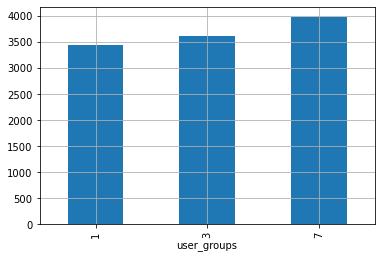

In [20]:
def f():
    _df = df.copy()
    
    _agg = _df.groupby(by='user_groups')['prod_t'].agg('mean')

    _agg.plot(kind='bar')
    plt.grid(True)
    plt.show()
f()

Различие по срочности исполнения между группами пользователей может составить до 500 минут (8 часов).

`7 = SP | РА | До`

Посмотрим, что это за заказы

In [29]:
display(df[df['user_groups'] == 7])
display('Всего изделий: ' + str(df.shape[0]))

,mmid,gs,prod_t,sum,user_groups,gsdate_ts,gsdate2_ts,userId,gsid,post_id,...,цветность перекидных листов,количество листов в блоке,вид значка,тип коробки,размер коробки,цвет ленты,цвет нанесения,способ упаковки,макет основы,добавить цепочку
1,1463859,ГППКПК,4457,9290.0,7,1642161600,1642429029,12.2307,ТСИЗ0601,221,...,,,,,,,,,,
4,1467211,ГППОВиФо,1998,3330.0,7,1641762000,1641881936,12.2312,ТСИЗ0201,1,...,,,,,,,,,,
7,1469090,ГППОКАКВ,2246,17500.0,7,1641848400,1641983195,12.1908,ТСИЗ0301,14,...,,,,,,,,,,
8,1469108,ГППОКАКВ,1040,17500.0,7,1641848400,1641910811,12.1908,ТСИЗ0301,14,...,,,,,,,,,,
14,1469624,ГППОБПТ3,643,3808.0,7,1642453200,1642491788,12.2312,ТСИЗ1901,301,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10220,1640993,ГПШрБМ02,4989,912.0,7,1659038814,1659338200,12.2237,ТСИЗ2401,23,...,,,,,,,,,,
10221,1640997,ГПШрБМ02,4987,183.0,7,1659038953,1659338192,12.2237,ТСИЗ2401,23,...,,,,,,,,,,
10222,1641001,ГПШрПЛ01,4987,284.0,7,1659038953,1659338232,12.2237,ГПШрПЛ,22,...,,,,,,,,,,
10224,1641014,ГПШрПЛ02,4462,2544.0,7,1659096000,1659363777,12.2237,ГПШрПЛ,22,...,,,,,,,,,,


'Всего изделий: 10228'

46% заказов делается в среднем на 8 часов быстрее в связи с особой группой клиента

<a id="model"></a>
### Обучение

Подготовка моделей вынесена в отдельный блокнот
- [train.ipynb](./train.ipynb)

In [5]:
f = open('./reports/train_report.json', 'r', encoding='utf-8')
_report = json.loads(''.join(f.readlines()))

pd.DataFrame(_report)

,name,r2,mse,gscv_best_params_,gscv_best_score_
0,LinearRegression,0.21,3736593,{},-1.361421e+25
1,GradientBoostingRegressor,0.33,3158266,"{'n_estimators': 500, 'random_state': 128}",3.802516e-01
2,BaggingRegressor,0.33,3154409,"{'base_estimator': None, 'random_state': 128}",4.412766e-01
3,AdaBoostRegressor,0.26,3492974,{'base_estimator': ExtraTreeRegressor()},4.211485e-01
4,RandomForestRegressor,0.36,3010112,{'n_estimators': 1000},4.857085e-01


Результаты неутешительные.  
Отобранная лучшая модель среди обученных, вернула результат по r2_score выше чем у калькулятора: 0.36 > -0.5.  
Но, несмотря на то, что это существенно лучше, чем первоначальный прогноз калькулятора, это всё равно очень низкий уровень прогнозирования.  
Расхождение в 1000 минут и свыше.

Аугментация данных в виде признаков "weekday", "prod_load", "user_groups" не привели к радикальному улучшению прогнозируемости. (их корреляция приведена в разделе "анализ")

Надежда на то, что срок производства конечного изделия будет линейной комбинацией сроков работ из которого изделие состоит, похоже, не оправдались. Унитарное кодирование (onehot-encoding) некоторых признаков лишь ухудшили результат:
- способ печати
- контурная порезка на рулоне
- ламинация
- выборка порезки
- порезка на отдельные изделия
- разрезать на блоки
- двойной проход печати

Модель регрессии на основе многослойного перцептрона показала себя еще хуже. Практически бесполезно.

Скорее всего, существуют какие-то необнаруженные мною скрытые параметры.

В перспективе имеет смысл попробовать отдельно прогнозировать сроки каждого этапа производства, а затем их суммировать.